In [1]:
# Submarine melting Qsm under different icefront temperature and sill depths
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt

In [7]:
# Melting flux at ice front
def IFA(case_path, case_id):
    # Grid areas    
    Area = np.empty([90, 10])
    Area[:20,:] = 400
    Area[20:50,:] = 800
    Area[50:,:] = 1200

    file0 = xr.open_dataset(case_path + '/icefrntA_' + str(format(case_id,'03d')) + '.nc')
    t0 = 89
    #tn = 120
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(Y=range(35,45), T=range(t0,len(file.T)))
    
    MR = state.icefrntA.isel(X=1).data.mean(0) # Melt rate at the icefront
    Qsm = (MR*Area).sum()/(24*3600)
    return Qsm

In [8]:
# Water temperature at ice front
def icefrntT(case_path, case_id):
    File1 = xr.open_dataset(case_path + '/state_' + str(format(case_id,'03d')) + '.nc')
    Grid = xr.open_dataset(case_path + '/grid_' + str(format(case_id,'03d')) + '.nc')  
    State = File1.isel(T=~File1.get_index("T").duplicated())
    
    # Confine to the range of fjord
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(89,len(State.T)))
    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
   
    t0 = 0 # Starting time index
    da = DA[t0:,:,:,1].mean(axis=(0,2))
    Ti = state.Temp.data[t0:,:,:,1].mean(axis=(0,2))
    Ui = U[t0:,:,:,1].mean(axis=(0,2))
    
    Tvi = np.sum(Ti*da) / np.sum(da)
    return Tvi

In [4]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/Qsg050hs'
path2 = '/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase' # Qsg=250
path3 = '/work/oceans/wbao/MITgcm_results/iceplume/Qsg500hs'

caseN = np.array([1,2,3,4,5,6])

Qsm1 = np.empty(len(caseN))
Tice1 = np.empty(len(caseN))

Qsm2 = np.empty(len(caseN))
Tice2 = np.empty(len(caseN))

Qsm3 = np.empty(len(caseN))
Tice3 = np.empty(len(caseN))

for i in range(len(caseN)):
    
    Qsm1[i] = IFA(path1, caseN[i])
    Tice1[i] = icefrntT(path1, caseN[i])
    
    Qsm2[i] = IFA(path2, caseN[i])
    Tice2[i] = icefrntT(path2, caseN[i])
    
    Qsm3[i] = IFA(path3, caseN[i])
    Tice3[i] = icefrntT(path3, caseN[i])

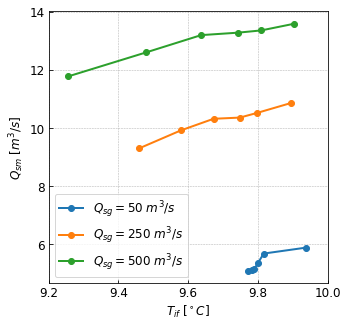

In [5]:
fig1, ax1 = plt.subplots(figsize=(5,5))
plt.grid(linestyle = '--', linewidth = 0.5)

#plt.axis('square')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'$T_{if}\;[^\circ C]$', size=12)
plt.ylabel(r'$Q_{sm}\;[m^3/s]$',size=12)

ax1.plot(np.sort(Tice1), np.sort(Qsm1), 'o-', ms=6,lw=2,label=r'$Q_{sg}=50\;m^3/s$')
ax1.plot(np.sort(Tice2), np.sort(Qsm2), 'o-', ms=6,lw=2,label=r'$Q_{sg}=250\;m^3/s$')
ax1.plot(np.sort(Tice3), np.sort(Qsm3), 'o-', ms=6,lw=2,label=r'$Q_{sg}=500\;m^3/s$')
ax1.legend(loc='best', fontsize=12)
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlim([9.2, 10])

#ax1.set_xticks([0.04, 0.06, 0.08, 0.10, 0.12])
plt.show()

In [9]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_minhs'
path2 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_nosill'

caseN = np.array([1,2,3,4,5])

Qsm1 = np.empty(len(caseN))
Tice1 = np.empty(len(caseN))

Qsm2 = np.empty(len(caseN))
Tice2 = np.empty(len(caseN))


for i in range(len(caseN)):
    
    Qsm1[i] = IFA(path1, caseN[i])
    Tice1[i] = icefrntT(path1, caseN[i])
    
    Qsm2[i] = IFA(path2, caseN[i])
    Tice2[i] = icefrntT(path2, caseN[i])

In [10]:
Qsm1, Tice1, Qsm2, Tice2

(array([5.98981555, 6.10563305, 6.85205652, 8.87824692, 9.58235464]),
 array([8.87177824, 8.99560188, 8.93084422, 9.09636703, 9.28237592]),
 array([5.11334446, 5.57730199, 6.42534292, 7.81707443, 8.58837926]),
 array([9.88115542, 9.88382674, 9.88802081, 9.86293875, 9.88767712]))

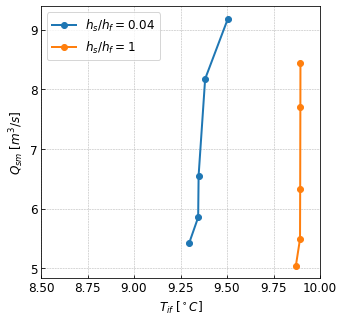

In [6]:
fig2, ax1 = plt.subplots(figsize=(5,5))
plt.grid(linestyle = '--', linewidth = 0.5)

#plt.axis('square')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'$T_{if}\;[^\circ C]$', size=12)
plt.ylabel(r'$Q_{sm}\;[m^3/s]$',size=12)

ax1.plot(np.sort(Tice1), np.sort(Qsm1), 'o-', ms=6,lw=2,label=r'$h_s/h_f=0.04$')
ax1.plot(np.sort(Tice2), np.sort(Qsm2), 'o-', ms=6,lw=2,label=r'$h_s/h_f=1$')
ax1.legend(loc='best', fontsize=12)
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlim([8.5, 10])

#ax1.set_xticks([0.04, 0.06, 0.08, 0.10, 0.12])
plt.show()

In [26]:
def Qsm_prof(datapath, case_id):
    
    State01 = xr.open_dataset(datapath + '/state_' + str(format(case_id,'03d')) + '.nc')    
    State = State01.isel(T=~State01.get_index("T").duplicated())
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45))
    
    depth = state.Z.data
    time = state.T.data[1:] / 86400 # Time in days
    
    # Grid areas    
    Area = np.empty(90)
    Area[:20] = 400
    Area[20:50] = 800
    Area[50:] = 1200

    file0 = xr.open_dataset(datapath + '/icefrntA_' + str(format(case_id,'03d')) + '.nc')
    t0 = 0
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(Y=range(35,45), T=range(t0,len(file.T)))
    
    MR = state.icefrntA.isel(X=1).data.mean(2) # Melt rate at the icefront
    Qsm = (MR*Area*10) / (24*3600)
    
    return depth, time, Qsm

In [47]:
depth, time, MR1 = Qsm_prof(path1, 4)
depth, time, MR2 = Qsm_prof(path2, 4)

In [48]:
#time.shape, MR1.shape
MR2.max(), MR2.min()

(0.15220953358544242, 0.028303832643561892)

Text(0, 0.5, 'Depth [$m$]')

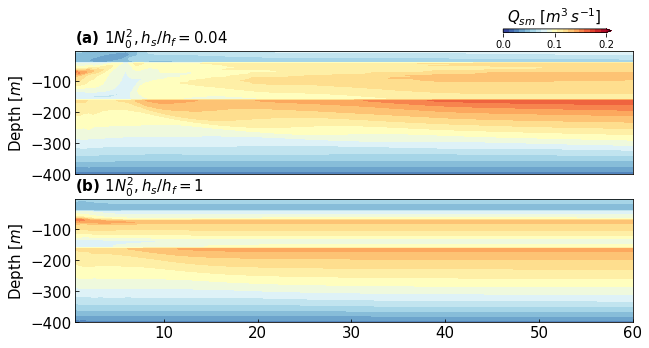

In [50]:
# Making plot for glacier front Qsm transition
fig3 = plt.figure(figsize=(10,5))
fig3.tight_layout()  

cmr = np.linspace(0,0.2,20) # Contour range for U
#crho = np.linspace(10,25,15) # Contour range for density
cmap = 'RdYlBu_r'

hs = 16
ax1 = fig3.add_subplot(211)
im1 = ax1.contourf(time, depth, MR1.T, cmr, cmap=cmap, extend='max')
#ax1.axhline(y=-hs,color='k',linestyle='--')

# Plot isopycnals
#CS1 = ax1.contour(time, depth, Rho1-1000, crho, colors='k', linewidths=.5)
#plt.clabel(CS1, fmt='%1.1f', fontsize=12, inline=1)

cbaxes = fig3.add_axes([0.72, 0.93, 0.15, 0.01])
cbar = fig3.colorbar(im1,cax=cbaxes, orientation='horizontal')
cbar.set_ticks([0, 0.1, 0.2])
cbar.ax.set_title('$Q_{sm}$ [$m^3\,s^{-1}$]', size=15)

ax1.set_xlim(time[0],time[-1])
ax1.set_ylim(-400,depth[0])
ax1.xaxis.set_visible(False)
ax1.tick_params(direction='in', labelsize=15)
ax1.set_title('(a) $1N_0^2, h_s/h_f=0.04$', loc='left', size=15, weight='bold')
ax1.set_ylabel('Depth [$m$]', size=15)


ax2 = fig3.add_subplot(212)
im2 = ax2.contourf(time, depth, MR2.T, cmr, cmap=cmap, extend='max')
#ax2.axhline(y=-hs,color='k',linestyle='--')

# Plot isopycnals
#CS1 = ax1.contour(time, depth, Rho1-1000, crho, colors='k', linewidths=.5)
#plt.clabel(CS1, fmt='%1.1f', fontsize=12, inline=1)

ax2.set_xlim(time[0],time[-1])
ax2.set_ylim(-400,depth[0])
#ax1.xaxis.set_visible(False)
ax2.tick_params(direction='in', labelsize=15)
ax2.set_title('(b) $1N_0^2, h_s/h_f=1$', loc='left', size=15, weight='bold')
ax2.set_ylabel('Depth [$m$]', size=15)

In [51]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
#fig1.savefig(fig_path + '/Qsm_Tif.png', dpi=200, bbox_inches='tight')
fig3.savefig(fig_path + '/Qsm_transition.png', dpi=300, bbox_inches='tight') 